# HMM to estimate Funnel position

## Import libraries and constants

In [1]:
import matplotlib.pyplot as plt

import config.CONSTANTS_HMM
from config.CONSTANTS_HMM import *
from config.execution_parameters import *

# Project libraries
import src.hmm_package.generate_hmm
from src.hmm_package.generate_hmm import *
from src.plot_and_print_info.plots_and_print_info import *

# Built in libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import importlib

In [2]:
importlib.reload(src.hmm_package.generate_hmm)
from src.hmm_package.generate_hmm import *
importlib.reload(config.CONSTANTS_HMM)
from config.CONSTANTS_HMM import *

## Compute Observation and Adstock

In [3]:
# Generate Test observation
observation = simulate_observations()

# Compute Adstock
adstock = compute_adstock(observation=observation)

2022-04-05 09:11:16.444276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Real HMM to Estimate

In [4]:
# Generate the distributions to build the Real HMM
#NB The variable STATES_ARE_OBSERVABLE is set in config/execution_parameters.
hmm_distributions = generate_hmm_distributions(states_observable=False, adstock=adstock)

# Create Real HMM to fit
real_hmm = tfd.HiddenMarkovModel(
    initial_distribution=hmm_distributions['initial_distribution'],
    transition_distribution=hmm_distributions['transition_distribution'],
    observation_distribution=hmm_distributions['observation_distribution'],
    time_varying_transition_distribution=True,
    num_steps=time+1
)

# Sample emissions
emission_real = real_hmm.sample().numpy()

In [ ]:
sing_dist = generate_hmm_distributions(states_observable=False, adstock=adstock[0:1])

# Create Real HMM to fit
single = tfd.HiddenMarkovModel(
    initial_distribution=sing_dist['initial_distribution'],
    transition_distribution=sing_dist['transition_distribution'],
    observation_distribution=sing_dist['observation_distribution'],
    time_varying_transition_distribution=True,
    num_steps=time+1
)

In [ ]:
a = single.sample()
a

In [ ]:
loss_function(a,single)

In [ ]:
tf.reduce_sum(tf.math.multiply(tf.exp(single.posterior_marginals(a).logits),tf.exp(single.prior_marginals().logits)))


In [ ]:
single.prior_marginals().logits[:, :, -1]

In [ ]:
prior_probs = tf.exp(single.prior_marginals().logits[:, :, -1])
tf.reduce_sum(1 - prior_probs[tf.math.equal(a,1)]) + tf.reduce_sum(prior_probs[a == 0])

### Visualize the Real HMM

5097


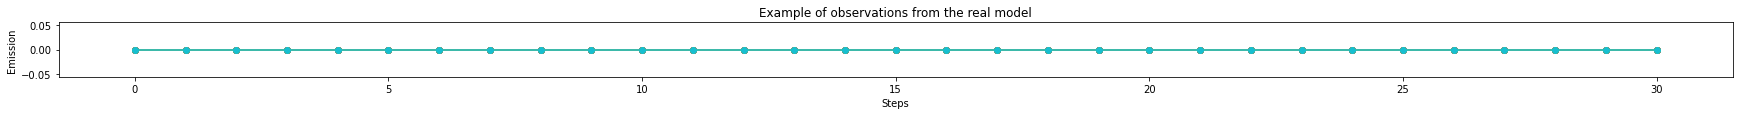

In [5]:
# Count conversions from sampled data
tot_conversions = count_conversions(emission_real, STATES_ARE_OBSERVABLE)

plot_sample_emissions(real_hmm)

## Build model to fit

In [6]:
# STATES_ARE_OBSERVABLE is defined in CONSTANTS_HMM
model = build_hmm_to_fit_beta( states_observable=STATES_ARE_OBSERVABLE, mu=MU )

compiler = CompilerInfoBeta(LR_EXPONENTIAL_DECAY)
model.compile(
    loss = compiler.loss,
    optimizer = compiler.optimizer,
    run_eagerly = True
)

2022-04-05 09:12:02.877783: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Fit the model

In [7]:
history = fit_model(model, adstock, emission_real)

Beta: [array([ 1. ,  0.5, -0.5,  0.5,  0.5,  0.5, -0.5,  1. ], dtype=float32)]
Epoch 1/1000
40/40 [==============================] - 70s 2s/step - loss: 2521.9929
Beta: [array([ 0.96875405,  0.5027109 , -0.49212813,  0.48933432,  0.4684948 ,
        0.49776706, -0.4920853 ,  0.98868746], dtype=float32)]
Epoch 2/1000
40/40 [==============================] - 68s 2s/step - loss: 2484.6792
Beta: [array([ 0.95312434,  0.508482  , -0.4838513 ,  0.47934026,  0.44853368,
        0.5022312 , -0.4840446 ,  0.9787639 ], dtype=float32)]
Epoch 3/1000
40/40 [==============================] - 68s 2s/step - loss: 2456.4485
Beta: [array([ 0.9374098 ,  0.5140682 , -0.47750312,  0.47145194,  0.42875928,
        0.50628877, -0.4774911 ,  0.97087646], dtype=float32)]
Epoch 4/1000
40/40 [==============================] - 69s 2s/step - loss: 2422.4978
Beta: [array([ 0.91986376,  0.51734906, -0.46923214,  0.46207637,  0.40857574,
        0.5064704 , -0.46878752,  0.96123344], dtype=float32)]
Epoch 5/1000
40/4

KeyboardInterrupt: 

In [17]:
tf.reduce_sum(make_transition_matrix(MU, [ 0.60443544,  0.6717377 , -0.23794842,  0.28381994, -0.        ,
        1.0300579 , -0.29468915,  0.808104  ], adstock[0:1]) - make_transition_matrix(MU,BETA, adstock[0:1]), axis=1)/30

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 0.08950578, -0.09371506,  0.00420926],
        [-0.02535208,  0.02153634,  0.00381574],
        [ 0.        ,  0.        ,  0.        ]]], dtype=float32)>

In [ ]:
BETA